<CIExyY CIE1931 'D65:( 0.313435243461, 0.323576777770)>

<CIExyY CIE1931 'D65:( 0.313497532554, 0.323637442792)>

0.313432036002229

WhitePoint (Chromaticity <CIExyY CIE1931 'D65:( 0.312720000000, 0.329030000000)>)

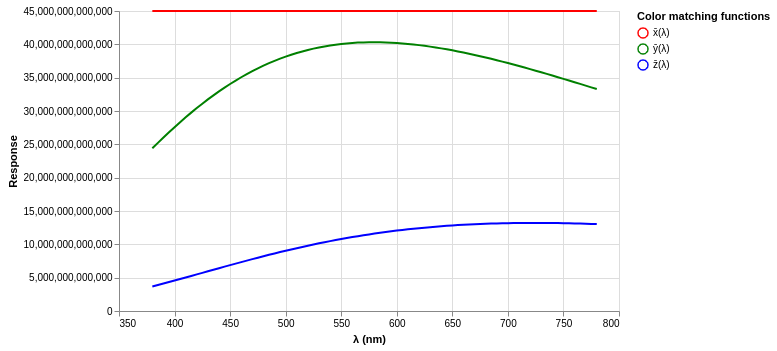

In [122]:
import Demo
import Data.Massiv.Array as A
import Data.Massiv.Array.IO as A
import Data.Massiv.Array.Numeric.Integral
import Graphics.Color.Space
import Graphics.Color.Illuminant.CIE1931 as CIE1931
import Graphics.Vega.VegaLite as VL hiding (Color)
import IHaskell.Display.Hvega
import Control.Monad as Monad
import Data.Foldable as F

spectralRadiantExitanceBackwards c2 k temperature lambda = c1 / (lambda ^ (5 :: Int)) * recip (exp (c2 / (lambda * temperature) - 1))
  where
  c = 299792458 -- speed of light m / s
  -- Normal formula for c1, but we want to compute it from c2 instead
  --c1 = 2 * pi * h * c 
  c1 = 2 * pi * c2 * c * k
  -- Normla formula for k
  --c2 = h * c / k
-- Values for c2:
_c2_ITS_27 = 1.432e-2 -- ITS-27 (from 1927)
_c2_CIE1931 = 1.435e-2 -- Used for A B C (1931) - value suggested by U.S. National Bureau of Standards
_c2_IPTS_48 = 1.4380e-2 -- IPTS-48 was used for D illuminants in 1967
_c2_ITS_68 = 1.4388e-2 -- ITS-68 and ITS-90
_c2_CODATA_2006 = 1.4387752e-2 -- (CODATA-1998 - CODATA-2006) - Standard uncertainty 0.0000025, relative standard uncertainty: 1.7e-6
_c2_CODATA_2010 = 1.438777013131313e-2
_c2_CODATA_2014 = 1.4387773683838383e-2
_c2_CODATA_2018 = 1.438776877e-2 -- Source: https://physics.nist.gov/cgi-bin/cuu/Value?c22ndrc
_c2_computed = 6.62607015e-34 * 2.99792458e8 / 1.380649e-23 -- h * c / k = 1.4387768775039337e-2

-- | Function for computing black body spectral radiant exitance (power per unit area per unit wavelength: watt per square meter per meter (W/m3))
spectralRadiantExitance temperature lambda =
  (c1 / (lambda' ^ (5 :: Int))) * 1 / (exp (c2 / (lambda' * temperature)) - 1)
  where
    lambda' = lambda * 1e-9
    c = 2.99792458e8 -- speed of light: m / s
    h = 6.62607015e-34 -- Planck's constant: J * s
    k = 1.380649e-23 -- Boltzmann's constant: J * K-1
    c1 = 2 * pi * h * (c ^ (2 :: Int))
    c2 = _c2_IPTS_48 -- h * c / k

wavelengths :: Array P Ix2 Double
wavelengths = A.compute $ A.makeLoadArrayS (Sz (length CIE1931.colorMatchingFunctions :. 4)) 0 $ \ writeCell ->
  let writeColumn i (w, V3 x y z, _) = do writeCell (i :. 0) w
                                          writeCell (i :. 1) x
                                          writeCell (i :. 2) y
                                          writeCell (i :. 3) z
  in Monad.zipWithM_ writeColumn [0..] CIE1931.colorMatchingFunctions 

-- wavelength :: Array P Ix2 Double
-- wavelength = A.createArrayST_ Seq (Sz (length CIE1931.colorMatchingFunctions :. 4)) $ \ ma ->
--   let writeColumn i (w, V3 x y z, _) = do writeM ma (i :. 0) w
--                                           writeM ma (i :. 1) x
--                                           writeM ma (i :. 2) y
--                                           writeM ma (i :. 3) z
--   in Monad.zipWithM_ writeColumn [0..] CIE1931.colorMatchingFunctions 

-- :set -XDataKinds
-- :set -XPolyKinds
-- planckianLocus :: Double -> Color (XYZ 'D65) Double
-- planckianLocus temperature = xyz -- / pure (minimum xyz)
--   where ls = A.computeAs P $ A.map ((5 *) . spectralRadiantExitance temperature) (wavelengths <! 0)
--         x = either throw A.sum (delay ls .*. delay (wavelengths <! 1) >>= (.*.) (delay (wavelengths <! 0)))
--         y = either throw A.sum (delay ls .*. delay (wavelengths <! 2) >>= (.*.) (delay (wavelengths <! 0)))
--         z = either throw A.sum (delay ls .*. delay (wavelengths <! 3) >>= (.*.) (delay (wavelengths <! 0)))
--         xyz = ColorXYZ x y z
-- fromColorXYZ $ planckianLocus 6500 :: Color (CIExyY 'D65) Double
-- print (whitePoint :: WhitePoint 'D65 Double)

integrateNaive :: Array P Ix1 Double -> Double
integrateNaive arr = fst $ A.foldlS sumWith (0, y0') arr'
    where
      Just (y0', arr') = unconsM arr
      step = 5
      area y0 y1 = step * (y0 + y1) / 2
      sumWith (acc, y0) y1 =
        let acc' = acc + area y0 y1
         in acc' `seq` (acc', y1)

:set -XDataKinds
:set -XPolyKinds
planckianLocus :: Double -> Color (XYZ 'D65) Double
planckianLocus temperature = xyz -- (ls, x, y , z)
  where ls = A.computeAs P $ A.map (spectralRadiantExitance temperature) (wavelengths <! 0)
        x = either throw (integrateNaive . A.computeAs P) (delay ls .*. delay (wavelengths <! 1))
        y = either throw (integrateNaive . A.computeAs P) (delay ls .*. delay (wavelengths <! 2))
        z = either throw (integrateNaive . A.computeAs P) (delay ls .*. delay (wavelengths <! 3))
        xyz = ColorXYZ x y z
fromColorXYZ $ planckianLocus 6504 :: Color (CIExyY 'D65) Double
fromColorXYZ $ planckianLocus 6500 :: Color (CIExyY 'D65) Double

xc t = (-3.0258469) * (10 ^ (9 :: Int)) / (t ^ (3 :: Int)) + 2.1070379 * (10 ^ (6 :: Int)) / (t ^ (2 :: Int)) + 0.2226347 * (10 ^ (3 :: Int)) / t + 0.24039

xc 6504
print (whitePoint :: WhitePoint 'D65 Double)

:set -XOverloadedStrings

plotcmf = toVegaLite
  [ description "CIE 1931 Color Matching Functions"
  , background "white"
  , cie1931cmf
  , transform . foldAs ["x̄(λ)", "ȳ(λ)", "z̄(λ)"] "Color matching functions" "Response"$ []
  , mark Line []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Response", PmType Quantitative]
    . color [ MName "Color matching functions", MmType Nominal , MScale [SDomain (DStrings ["x̄(λ)", "ȳ(λ)", "z̄(λ)"]), SRange (RStrings ["Red", "Green", "Blue"])] ]
    $ []
  , height 300
  , width 500
  ]
  where
    cie1931cmf = dataFromColumns []
               . dataColumn "λ (nm)" (Numbers [w | (w, _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "600" (Numbers [spectralRadiantExitance 6500 w | (w, V3 x _ _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "ȳ(λ)" (Numbers [spectralRadiantExitance 5000 w | (w, V3 _ y _, _) <- CIE1931.colorMatchingFunctions])
               . dataColumn "z̄(λ)" (Numbers [spectralRadiantExitance 4000 w | (w, V3 _ _ z, _) <- CIE1931.colorMatchingFunctions])
               $ []
vlShow plotcmf

Line 22: Redundant bracket
Found:
(w)
Why not:
w

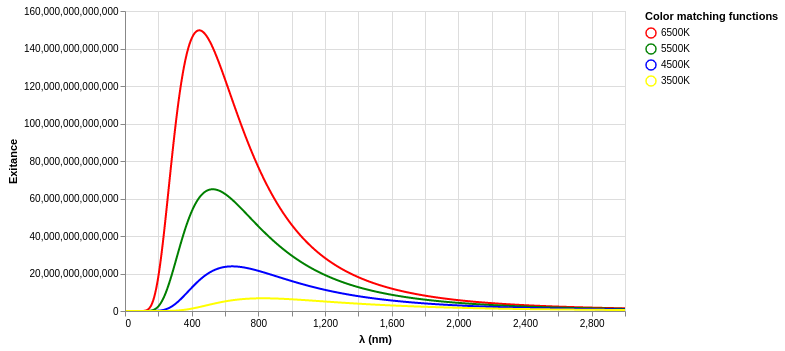

In [128]:
import qualified Data.Text as T

plotcmf = toVegaLite
  [ description "Spectral radiant exitance"
  , background "white"
  , height 300
  , width 500
  , mark Line []
  , dataFromColumns []
    . dataColumn "λ (nm)" (Numbers wavelengths)
    . foldl mkColumn id temperatures
    $ []
  , transform . foldAs (fst <$> temperatures) "Color matching functions" "Exitance" $ []
  , encoding 
    . position VL.X [PName "λ (nm)", PmType Quantitative]
    . position VL.Y [PName "Exitance", PmType Quantitative]
    . color [ MName "Color matching functions", MmType Nominal , MScale [SDomain (DStrings (fst <$> temperatures)), SRange (RStrings ["Red", "Green", "Blue", "Yellow"])] ]
    $ []
  ]
  where
    temperatures = [(T.pack (show (round t)) <> "K", t) | t <- [6500, 5500, 4500, 3500]]
    wavelengths = [w | (w) <- [0, 5 .. 3000 :: Double]] -- CIE1931.colorMatchingFunctions]
    mkColumn acc (tn, t) = dataColumn tn (Numbers (spectralRadiantExitance t <$> wavelengths)) . acc
vlShow plotcmf


In [ ]:
2 * pi * 4.135667696e-15 * 2.99792458e8

In [ ]:
6.62607015e-34 * 2.99792458e8 / 1.380649e-23 -- h * c / k

In [ ]:
1.98644568e-25 / 1.380649e-23 -- hc / k
1.98644568e-25 /6.62607015e-34 -- computed speed of light from hc = 2.9979243126485765e8

In [ ]:
4.135667696e-15 * 2.99792458e8 / 8.617333262145e-15

In [ ]:
1.438777013131313e-2 :: Double

In [ ]:
1.4387773683838383e-2
1.438777368383838383e-2